# TB CODA

In [1]:
import math
import random
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib
import glob
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# seed value for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [2]:
def find_label(participant):
    return clinical_data['tb_status'][clinical_data['participant']==participant].to_list()[0] 

In [3]:
clinical_data = pd.read_csv("Clinical_Meta.csv")
metadata_solicited = pd.read_csv("Solicited_Meta.csv")
metadata_solicited

,participant,filename,sound_prediction_score
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039
...,...,...,...
9767,CODA_TB_1107,1658214018804-recording-1.wav,0.941761
9768,CODA_TB_1107,1658213992939-recording-1.wav,0.904569
9769,CODA_TB_1107,1658213992139-recording-1.wav,0.934713
9770,CODA_TB_1107,1658213940569-recording-1.wav,0.912813


In [4]:
label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
metadata_solicited['label'] = label
metadata_solicited['relative_path'] = 'solicited/' + metadata_solicited['filename']


# add all other colums from clinical data to metadata 
for col in clinical_data.columns:
    if col not in metadata_solicited.columns:
        metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())

# print columns
print(metadata_solicited.columns)

/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/2019973022.py:1: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  label = metadata_solicited['participant'].apply(find_label, convert_dtype=True, args=())
/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/2019973022.py:9: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  metadata_solicited[col] = metadata_solicited['participant'].apply(lambda x: clinical_data[col][clinical_data['participant']==x].to_list()[0], convert_dtype=True, args=())
/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/2019973022.py:9: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` i

Index(['participant', 'filename', 'sound_prediction_score', 'label',
       'relative_path', 'sex', 'age', 'height', 'weight', 'reported_cough_dur',
       'tb_prior', 'tb_prior_Pul', 'tb_prior_Extrapul', 'tb_prior_Unknown',
       'hemoptysis', 'heart_rate', 'temperature', 'weight_loss', 'smoke_lweek',
       'fever', 'night_sweats', 'tb_status'],
      dtype='object')


In [5]:
metadata_solicited['sex'] = metadata_solicited['sex'].map({'Male': 0, 'Female': 1})
metadata_solicited['tb_prior'] = metadata_solicited['tb_prior'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Pul'] = metadata_solicited['tb_prior_Pul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Extrapul'] = metadata_solicited['tb_prior_Extrapul'].map({'No': 0, 'Yes': 1})
metadata_solicited['tb_prior_Unknown'] = metadata_solicited['tb_prior_Unknown'].map({'No': 0, 'Yes': 1})
metadata_solicited['hemoptysis'] = metadata_solicited['hemoptysis'].map({'No': 0, 'Yes': 1})
metadata_solicited['weight_loss'] = metadata_solicited['weight_loss'].map({'No': 0, 'Yes': 1})
metadata_solicited['smoke_lweek'] = metadata_solicited['smoke_lweek'].map({'No': 0, 'Yes': 1})
metadata_solicited['fever'] = metadata_solicited['fever'].map({'No': 0, 'Yes': 1})
metadata_solicited['night_sweats'] = metadata_solicited['night_sweats'].map({'No': 0, 'Yes': 1})

# count number of NaN values
print(metadata_solicited.isnull().sum())


participant                0
filename                   0
sound_prediction_score     0
label                      0
relative_path              0
sex                        0
age                        0
height                    23
weight                     0
reported_cough_dur         0
tb_prior                  23
tb_prior_Pul               0
tb_prior_Extrapul          0
tb_prior_Unknown           0
hemoptysis                 0
heart_rate                 0
temperature                0
weight_loss                0
smoke_lweek                0
fever                      0
night_sweats               0
tb_status                  0
dtype: int64


In [6]:
# drop NaN values
metadata_solicited = metadata_solicited.dropna()

metadata_solicited = metadata_solicited.drop(columns=['tb_status', 'sound_prediction_score'])

metadata_solicited.head()



,participant,filename,label,relative_path,sex,age,height,weight,reported_cough_dur,tb_prior,tb_prior_Pul,tb_prior_Extrapul,tb_prior_Unknown,hemoptysis,heart_rate,temperature,weight_loss,smoke_lweek,fever,night_sweats
0,CODA_TB_0001,1645088710003-recording-1.wav,0,solicited/1645088710003-recording-1.wav,0,27,173.3,63.0,30,0.0,0,0,0,0,99,37.2,1,0,1,1
1,CODA_TB_0001,1645088760390-recording-1.wav,0,solicited/1645088760390-recording-1.wav,0,27,173.3,63.0,30,0.0,0,0,0,0,99,37.2,1,0,1,1
2,CODA_TB_0001,1645088760830-recording-1.wav,0,solicited/1645088760830-recording-1.wav,0,27,173.3,63.0,30,0.0,0,0,0,0,99,37.2,1,0,1,1
3,CODA_TB_0001,1645088710843-recording-1.wav,0,solicited/1645088710843-recording-1.wav,0,27,173.3,63.0,30,0.0,0,0,0,0,99,37.2,1,0,1,1
4,CODA_TB_0001,1645088759950-recording-1.wav,0,solicited/1645088759950-recording-1.wav,0,27,173.3,63.0,30,0.0,0,0,0,0,99,37.2,1,0,1,1


In [7]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
import importlib
import segmentation
importlib.reload(segmentation)
import matplotlib.pyplot as plt
from tqdm import tqdm

segmented_files_tbcoda = []

# Create a progress bar
progress_bar = tqdm(metadata_solicited['filename'], total=len(metadata_solicited['filename']))

for file_path in progress_bar:
    audio_file = '/Users/sudac/Documents/uofa/solicited/' + file_path
    x, fs = librosa.load(audio_file, sr=None)

    # Segment the cough
    cough_segments, cough_mask = segmentation.segment_cough(x, fs, cough_padding = 0.005, min_cough_len = 0.1)

    # Save segmented audio files
    output_dir = '/Users/sudac/Documents/uofa/solicited/audio_files_segmented/'
    os.makedirs(output_dir, exist_ok=True)

    for i, segment in enumerate(cough_segments):
        segment_file = os.path.join(output_dir, f"{file_path}")
        sf.write(segment_file, segment, fs)  # Using soundfile to write the audio file
        # Retrieve additional information from tbscreen DataFrame
        class_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'label'].values[0]
        gndr_a_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'sex'].values[0]
        age_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'age'].values[0]
        subject_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'participant'].values[0]
        # height_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'height'].values[0]
        # weight_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'weight'].values[0]
        # reported_cough_dur_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'reported_cough_dur'].values[0]
        # tb_prior_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'tb_prior'].values[0]
        # tb_prior_Pul_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'tb_prior_Pul'].values[0]
        # tb_prior_Extrapul_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'tb_prior_Extrapul'].values[0]
        # tb_prior_Unknown_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'tb_prior_Unknown'].values[0]
        # hemoptysis_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'hemoptysis'].values[0]
        # heart_rate_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'heart_rate'].values[0]
        # temperature_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'temperature'].values[0]
        # weight_loss_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'weight_loss'].values[0]
        # smoke_lweek_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'smoke_lweek'].values[0]
        # fever_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'fever'].values[0]
        # night_sweats_value = metadata_solicited.loc[metadata_solicited['filename'] == file_path, 'night_sweats'].values[0]
        # Append segmented file information to segmented_files list
        segmented_files_tbcoda.append({
            'filename': file_path,
            'label': class_value,
            'sex': gndr_a_value,
            'age': age_value,
            'participant': subject_value,
            # 'height': height_value,
            # 'weight': weight_value,
            # 'reported_cough_dur': reported_cough_dur_value,
            # 'tb_prior': tb_prior_value,
            # 'tb_prior_Pul': tb_prior_Pul_value,
            # 'tb_prior_Extrapul': tb_prior_Extrapul_value,
            # 'tb_prior_Unknown': tb_prior_Unknown_value,
            # 'hemoptysis': hemoptysis_value,
            # 'heart_rate': heart_rate_value,
            # 'temperature': temperature_value,
            # 'weight_loss': weight_loss_value,
            # 'smoke_lweek': smoke_lweek_value,
            # 'fever': fever_value,
            # 'night_sweats': night_sweats_value,
        })

    # Update the progress bar description
    progress_bar.set_postfix(file=file_path)

segmented_df_coda = pd.DataFrame(segmented_files_tbcoda)
print(len(segmented_df_coda))

100%|██████████| 9726/9726 [01:00<00:00, 159.81it/s, file=1658213974948-recording-1.wav]


7437


In [8]:
# get number of unique participants in segmented_df_coda
print(len(segmented_df_coda['participant'].unique()))

1064


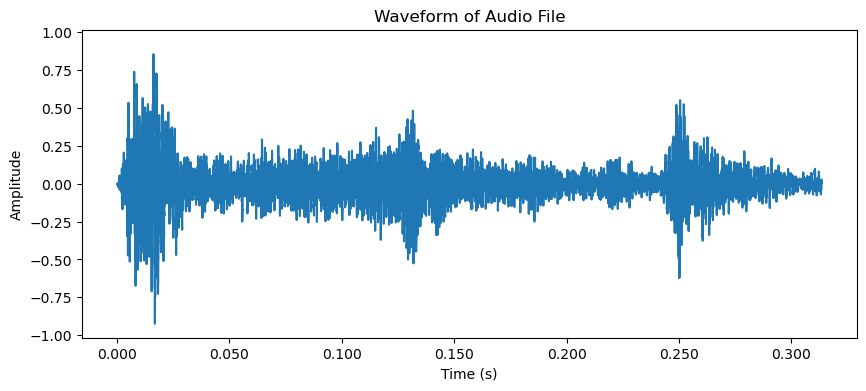

Length of audio: 0.3135600907029478 seconds


In [9]:
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = "/Users/sudac/Documents/uofa/solicited/audio_files_segmented/1635817629676-recording-1.wav"
y, sr = librosa.load(audio_file_path)

# Plot the waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform of Audio File")
plt.show()

# print length of audio
print(f"Length of audio: {len(y)/sr} seconds")


In [10]:
segmented_df_coda

,filename,label,sex,age,participant
0,1645088710003-recording-1.wav,0,0,27,CODA_TB_0001
1,1645088760390-recording-1.wav,0,0,27,CODA_TB_0001
2,1645088760830-recording-1.wav,0,0,27,CODA_TB_0001
3,1645088710843-recording-1.wav,0,0,27,CODA_TB_0001
4,1645088759950-recording-1.wav,0,0,27,CODA_TB_0001
...,...,...,...,...,...
7432,1658214038225-recording-1.wav,0,1,50,CODA_TB_1107
7433,1658214018804-recording-1.wav,0,1,50,CODA_TB_1107
7434,1658213992939-recording-1.wav,0,1,50,CODA_TB_1107
7435,1658213992139-recording-1.wav,0,1,50,CODA_TB_1107


In [11]:
segmented_df_coda['participant'].value_counts()

participant
CODA_TB_0244    40
CODA_TB_0973    40
CODA_TB_0878    36
CODA_TB_0766    33
CODA_TB_0129    30
                ..
CODA_TB_0312     1
CODA_TB_0894     1
CODA_TB_0490     1
CODA_TB_0884     1
CODA_TB_0736     1
Name: count, Length: 1064, dtype: int64

In [12]:
positive_patients = segmented_df_coda[segmented_df_coda['label'] == 1]['participant'].unique()
positive_patients_count = len(positive_patients)

negative_patients = segmented_df_coda[segmented_df_coda['label'] == 0]['participant'].unique()
negative_patients_count = len(negative_patients)

print("Number of unique positive patients:", positive_patients_count)
print("Number of unique negative patients:", negative_patients_count)


Number of unique positive patients: 286
Number of unique negative patients: 778


In [13]:
label_0_count = (segmented_df_coda[segmented_df_coda['label'] == 0]['participant']
                 .value_counts()
                 .loc[lambda x: x <= 3]
                 .count())

label_1_count = (segmented_df_coda[segmented_df_coda['label'] == 1]['participant']
                 .value_counts()
                 .loc[lambda x: x <= 3]
                 .count())

print("Number of patients with TB status 0 and 2 or fewer cough segments:", label_0_count)
print("Number of patients with TB status 1 and 2 or fewer cough segments:", label_1_count)


Number of patients with TB status 0 and 2 or fewer cough segments: 173
Number of patients with TB status 1 and 2 or fewer cough segments: 60


In [14]:
import pandas as pd
import numpy as np

# Filter out patients with 3 or fewer cough audio files
segmented_df_filtered = segmented_df_coda.groupby('participant').filter(lambda x: len(x) > 3)

# Ensure each patient has exactly 3 audio files
segmented_df_final = segmented_df_filtered.groupby('participant').apply(lambda x: x.sample(n=3, random_state=42) if len(x) > 3 else x)

# Reset index
segmented_df_final.reset_index(drop=True, inplace=True)

# Print the updated DataFrame
print(segmented_df_final)


                           filename  label  sex  age   participant
0     1645088710003-recording-1.wav      0    0   27  CODA_TB_0001
1     1645088760390-recording-1.wav      0    0   27  CODA_TB_0001
2     1645088784942-recording-1.wav      0    0   27  CODA_TB_0001
3     1643791201453-recording-1.wav      1    1   48  CODA_TB_0002
4     1643791127584-recording-1.wav      1    1   48  CODA_TB_0002
...                             ...    ...  ...  ...           ...
2488  1640314213990-recording-1.wav      1    1   63  CODA_TB_1106
2489  1640314255823-recording-1.wav      1    1   63  CODA_TB_1106
2490  1658214018804-recording-1.wav      0    1   50  CODA_TB_1107
2491  1658213940569-recording-1.wav      0    1   50  CODA_TB_1107
2492  1658213992939-recording-1.wav      0    1   50  CODA_TB_1107

[2493 rows x 5 columns]


/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/1300743369.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_df_final = segmented_df_filtered.groupby('participant').apply(lambda x: x.sample(n=3, random_state=42) if len(x) > 3 else x)


In [15]:
# Print the number of unique patients in segmented_df_final
num_unique_patients = segmented_df_final['participant'].nunique()
print("Number of unique patients in segmented_df_final:", num_unique_patients)

segmented_df_coda = segmented_df_final


Number of unique patients in segmented_df_final: 831


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Get unique participant IDs and their counts
participants_counts = segmented_df_coda['participant'].value_counts()

# Initialize empty DataFrames for train and test
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# Determine the number of participants for each split (adjust ratio as needed)
train_participants, test_participants = train_test_split(participants_counts.index, test_size=0.2, random_state=42)


# Filter data based on the selected participants
df_train = segmented_df_coda[segmented_df_coda['participant'].isin(train_participants)]
df_test = segmented_df_coda[segmented_df_coda['participant'].isin(test_participants)]

# Double-check to ensure participants are only in one split
assert set(df_train['participant'].unique()) & set(df_test['participant'].unique()) == set()


In [17]:
# check which split participant a certian patient is in
participant_id = 'CODA_TB_0001'

if df_train['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the train set')
if df_test['participant'].str.contains(participant_id).any():
    print(f'{participant_id} is in the test set')


CODA_TB_0001 is in the train set


In [18]:
df_train['label'].value_counts()

label
0    1434
1     558
Name: count, dtype: int64

In [19]:
df_test['label'].value_counts()

label
0    381
1    120
Name: count, dtype: int64

In [20]:
# print total number of unique participants in train and test set
print("Number of unique participants in the train set:", df_train['participant'].nunique())
print("Number of unique participants in the test set:", df_test['participant'].nunique())

Number of unique participants in the train set: 664
Number of unique participants in the test set: 167


In [21]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

def normalize_cough_duration(segmented_df_coda_train, target_duration_ms=500, fs=22050):
    normalized_coughs_train = []
    for index, row in segmented_df_coda_train.iterrows():
        # Load the cough audio data
        file_path = row['filename']
        audio_file = '/Users/sudac/Documents/uofa/solicited/audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_train.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_train.append(trimmed_signal)

    return normalized_coughs_train

def visualize_normalized_cough(normalized_coughs_train, index):
    if index >= len(normalized_coughs_train):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_train) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_train[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbcoda_train = normalize_cough_duration(df_train, target_duration_ms=500, fs=sr)
visualize_normalized_cough(normalized_coughs_tbcoda_train, 2431)  


Invalid index: 2431. Index should be between 0 and 1991.


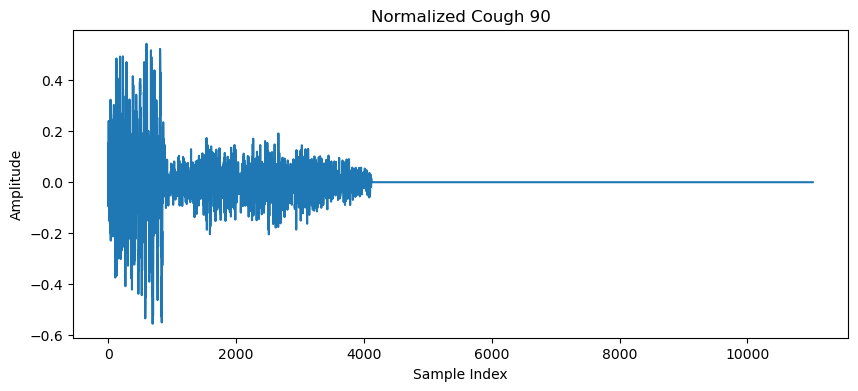

In [22]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

def normalize_cough_duration(segmented_df_coda_test, target_duration_ms=500, fs=22050):
    normalized_coughs_test = []
    for index, row in segmented_df_coda_test.iterrows():
        # Load the cough audio data
        file_path = row['filename']
        audio_file = '/Users/sudac/Documents/uofa/solicited/audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_test.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_test.append(trimmed_signal)

    return normalized_coughs_test

def visualize_normalized_cough(normalized_coughs_test, index):
    if index >= len(normalized_coughs_test):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_test) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_test[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbcoda_test = normalize_cough_duration(df_test, target_duration_ms=500, fs=sr)
visualize_normalized_cough(normalized_coughs_tbcoda_test, 90)  

In [23]:
import librosa
import numpy as np

def calc_mel_spectrogram(y, sr = 22050, n_fft = 2048, hop_length = 512, n_mels=64):
    spect = librosa.feature.melspectrogram(y=y, n_fft=n_fft, sr=sr, hop_length=hop_length, n_mels = n_mels)
    return librosa.power_to_db(spect, ref=np.max)

def read_audio(x):
    y = librosa.load(x)[0]
    return librosa.util.fix_length(y, size=11025)

In [24]:
# Calculate mel spectrograms

# list_audio_train = []
# for i in df_train['relative_path']:
#     list_audio_train.append(read_audio(i))

# list_audio_test = []
# for i in df_test['relative_path']:
#     list_audio_test.append(read_audio(i))

# mel_spectrogram_train = np.array(list(map(calc_mel_spectrogram, list_audio_train)))
# mel_spectrogram_test = np.array(list(map(calc_mel_spectrogram, list_audio_test)))

mel_spectrogram_train = np.array([calc_mel_spectrogram(y, 22050) for y in normalized_coughs_tbcoda_train])
mel_spectrogram_test = np.array([calc_mel_spectrogram(y, 22050) for y in normalized_coughs_tbcoda_test])
print(mel_spectrogram_train.shape, mel_spectrogram_test.shape)

(1992, 64, 22) (501, 64, 22)


# TB Screen

In [25]:
# opene TBscreen TBscreen/Forced coughs.csv
tbscreen = pd.read_csv('TBscreen/Forced coughs.csv')

# reorder the rows with  'gndr_a', 'age', 'prev_tb', 'extrapulmo_tb', 'cough_bld', 'un_wght_loss', 'smoke_lweek', 'fever', 'nght_swts'
tbscreen = tbscreen[['path', 'subject', 'class', 'gndr_a', 'age']]

print(tbscreen['subject'].nunique())

# remove rows with NaN values
tbscreen = tbscreen.dropna()

# print class ratio of class
tbscreen['class'].value_counts()

# print number of unique subjects
tbscreen['subject'].nunique()

50


47

In [26]:
tbscreen

,path,subject,class,gndr_a,age
0,PID_175A_0_codec,PID_175A,1.0,0.0,36.0
1,PID_175A_0_pixel,PID_175A,1.0,0.0,36.0
2,PID_175A0_yeti,PID_175A,1.0,0.0,36.0
3,PID_175A_1_codec,PID_175A,1.0,0.0,36.0
4,PID_175A_1_pixel,PID_175A,1.0,0.0,36.0
...,...,...,...,...,...
1200,PID_199A_now_C_19_codec,PID_199A_now_C,0.0,1.0,60.0
1201,PID_199A_now_C_20_codec,PID_199A_now_C,0.0,1.0,60.0
1202,PID_199A_now_C_22_yeti,PID_199A_now_C,0.0,1.0,60.0
1203,PID_199A_now_C_23_yeti,PID_199A_now_C,0.0,1.0,60.0


In [27]:
# drop the row with in any part of filename
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_183A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_192A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_198A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_207A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_218A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_224A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_225A')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_78C')]
tbscreen = tbscreen[~tbscreen['path'].str.contains('PID_199A')]

In [28]:
# print class ratio of class
tbscreen['class'].value_counts()

class
1.0    825
0.0    143
Name: count, dtype: int64

In [29]:
# print number of unique subjects
tbscreen['subject'].nunique()

38

In [30]:
y, sr = librosa.load('/Users/sudac/Documents/UofA/TBscreen/Audio_files/PID_73C_0_pixel.wav')
print(y.shape, sr)


(22050,) 22050


In [31]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

# Assuming you have a DataFrame named 'tbscreen' with columns 'path' and 'class'

segmented_files_tbscreen = []

# Create a progress bar
progress_bar = tqdm(tbscreen['path'], total=len(tbscreen['path']))

for file_path in progress_bar:
    audio_file = '/Users/sudac/Documents/UofA/TBscreen/Audio_files/' + file_path + '.wav'
    x, fs = librosa.load(audio_file, sr=None)

    # Segment the cough
    cough_segments, cough_mask = segment_cough(x, fs, cough_padding = 0.05, min_cough_len = 0.1)

    # Save segmented audio files
    output_dir = '/Users/sudac/Documents/UofA/TBscreen/Audio_files_segmented/'
    os.makedirs(output_dir, exist_ok=True)

    for i, segment in enumerate(cough_segments):
        segment_file = os.path.join(output_dir, f"{file_path}_{i}.wav")
        sf.write(segment_file, segment, fs)  # Using soundfile to write the audio file
        # Retrieve additional information from tbscreen DataFrame
        class_value = tbscreen.loc[tbscreen['path'] == file_path, 'class'].values[0]
        gndr_a_value = tbscreen.loc[tbscreen['path'] == file_path, 'gndr_a'].values[0]
        age_value = tbscreen.loc[tbscreen['path'] == file_path, 'age'].values[0]
        subject_value = tbscreen.loc[tbscreen['path'] == file_path, 'subject'].values[0]
        # Append segmented file information to segmented_files list
        segmented_files_tbscreen.append({
            'path': f"{file_path}_{i}.wav",
            'class': class_value,
            'gndr_a': gndr_a_value,
            'age': age_value,
            'subject': subject_value
        })

    # Update the progress bar description
    progress_bar.set_postfix(file=file_path)



segmented_df_tbscreen = pd.DataFrame(segmented_files_tbscreen)


100%|██████████| 968/968 [00:10<00:00, 95.53it/s, file=PID_82C_9_codec]     


In [32]:
segmented_df_tbscreen

,path,class,gndr_a,age,subject
0,PID_175A_0_codec_0.wav,1.0,0.0,36.0,PID_175A
1,PID_175A_0_pixel_0.wav,1.0,0.0,36.0,PID_175A
2,PID_175A0_yeti_0.wav,1.0,0.0,36.0,PID_175A
3,PID_175A_1_codec_0.wav,1.0,0.0,36.0,PID_175A
4,PID_175A_1_pixel_0.wav,1.0,0.0,36.0,PID_175A
...,...,...,...,...,...
926,PID_82C_7_codec_0.wav,0.0,1.0,25.0,PID_82C
927,PID_82C_8_pixel_0.wav,0.0,1.0,25.0,PID_82C
928,PID_82C_8_codec_0.wav,0.0,1.0,25.0,PID_82C
929,PID_82C_9_pixel_0.wav,0.0,1.0,25.0,PID_82C


In [33]:
positive_patients = segmented_df_tbscreen[segmented_df_tbscreen['class'] == 1]['subject'].unique()
positive_patients_count = len(positive_patients)

negative_patients = segmented_df_tbscreen[segmented_df_tbscreen['class'] == 0]['class'].unique()
negative_patients_count = len(negative_patients)

print("Number of unique positive patients:", positive_patients_count)
print("Number of unique negative patients:", negative_patients_count)


Number of unique positive patients: 34
Number of unique negative patients: 1


In [34]:
label_0_count = (segmented_df_tbscreen[segmented_df_tbscreen['class'] == 0]['class']
                 .value_counts()
                 .loc[lambda x: x <= 4]
                 .count())

label_1_count = (segmented_df_tbscreen[segmented_df_tbscreen['class'] == 1]['class']
                 .value_counts()
                 .loc[lambda x: x <= 4]
                 .count())

print("Number of patients with TB status 0 and 2 or fewer cough segments:", label_0_count)
print("Number of patients with TB status 1 and 2 or fewer cough segments:", label_1_count)


Number of patients with TB status 0 and 2 or fewer cough segments: 0
Number of patients with TB status 1 and 2 or fewer cough segments: 0


In [35]:
import pandas as pd
import numpy as np

# Filter out patients with 3 or fewer cough audio files
segmented_df_filtered = segmented_df_tbscreen.groupby('subject').filter(lambda x: len(x) > 3)

# Ensure each patient has exactly 3 audio files
segmented_df_final = segmented_df_filtered.groupby('subject').apply(lambda x: x.sample(n=3, random_state=42) if len(x) > 3 else x)

# Reset index
segmented_df_final.reset_index(drop=True, inplace=True)

# Print the updated DataFrame
print(segmented_df_final)


/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/2807358914.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  segmented_df_final = segmented_df_filtered.groupby('subject').apply(lambda x: x.sample(n=3, random_state=42) if len(x) > 3 else x)


                       path  class  gndr_a   age   subject
0    PID_175A_0_codec_0.wav    1.0     0.0  36.0  PID_175A
1    PID_175A_9_pixel_0.wav    1.0     0.0  36.0  PID_175A
2    PID_175A_8_pixel_0.wav    1.0     0.0  36.0  PID_175A
3     PID_177A_0_yeti_0.wav    1.0     0.0  27.0  PID_177A
4    PID_177A_8_pixel_0.wav    1.0     0.0  27.0  PID_177A
..                      ...    ...     ...   ...       ...
109  PID_80C_17_codec_0.wav    0.0     1.0  34.0   PID_80C
110  PID_80C_10_pixel_0.wav    0.0     1.0  34.0   PID_80C
111   PID_82C_0_pixel_0.wav    0.0     1.0  25.0   PID_82C
112   PID_82C_8_codec_0.wav    0.0     1.0  25.0   PID_82C
113   PID_82C_7_codec_0.wav    0.0     1.0  25.0   PID_82C

[114 rows x 5 columns]


In [36]:
# Print the number of unique patients in segmented_df_final
num_unique_patients = segmented_df_final['subject'].nunique()
print("Number of unique patients in segmented_df_final:", num_unique_patients)

segmented_df_tbscreen = segmented_df_final


Number of unique patients in segmented_df_final: 38


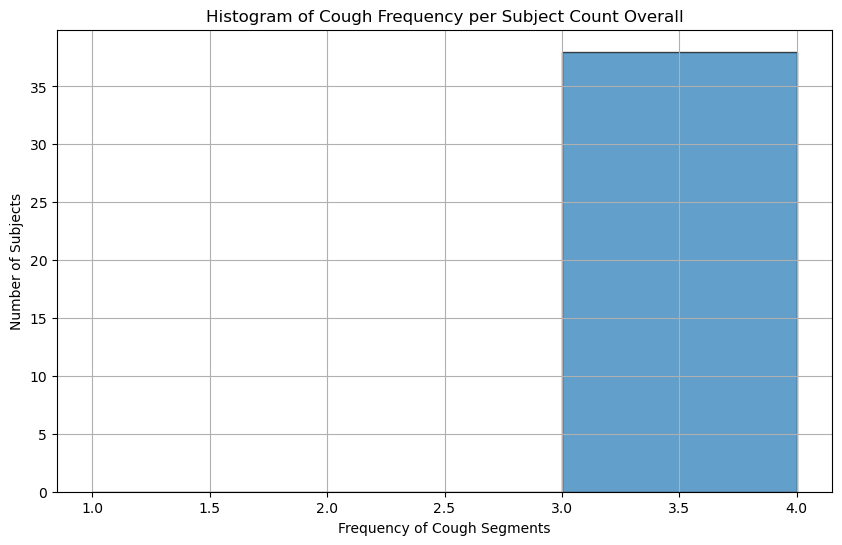

In [37]:
import matplotlib.pyplot as plt

subject_counts = segmented_df_tbscreen['subject'].value_counts()

plt.figure(figsize=(10, 6))
plt.hist(subject_counts, bins=range(1, subject_counts.max() + 2), edgecolor='black', alpha=0.7)

plt.xlabel('Frequency of Cough Segments')
plt.ylabel('Number of Subjects')
plt.title('Histogram of Cough Frequency per Subject Count Overall')

plt.grid(True)
plt.show()


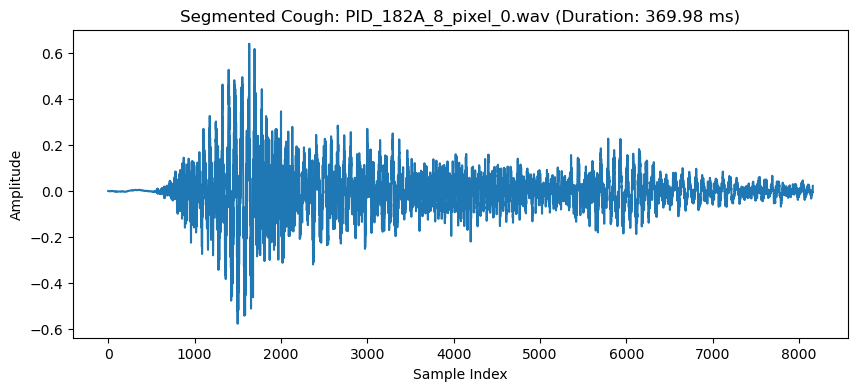

In [38]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt


def visualize_cough(segmented_df_tbscreen, index, fs):
    # Get the file path and load the audio data
    file_path = segmented_df_tbscreen.loc[index, 'path']
    audio_file = '/Users/sudac/Documents/UofA/TBscreen/Audio_files_segmented/' + file_path
    cough_data, _ = librosa.load(audio_file, sr=fs)

    # Calculate the duration in milliseconds
    duration_ms = len(cough_data) / fs * 1000

    # Visualize the cough segment
    plt.figure(figsize=(10, 4))
    plt.plot(cough_data)
    plt.title(f"Segmented Cough: {file_path} (Duration: {duration_ms:.2f} ms)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
visualize_cough(segmented_df_tbscreen, 12, 22050)

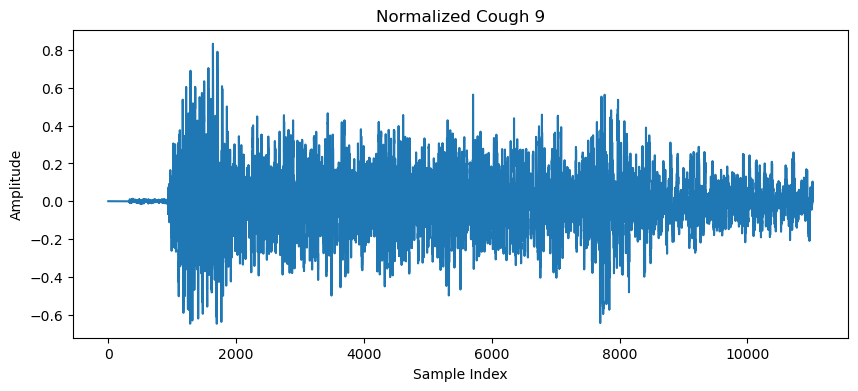

In [39]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt

def normalize_cough_duration(segmented_df_tbscreen, target_duration_ms=500, fs=22050):
    normalized_coughs_tbscreen = []
    for index, row in segmented_df_tbscreen.iterrows():
        # Load the cough audio data
        file_path = row['path']
        audio_file = '/Users/sudac/Documents/UofA/TBscreen/Audio_files_segmented/' + file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_tbscreen.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_tbscreen.append(trimmed_signal)

    return normalized_coughs_tbscreen

def visualize_normalized_cough(normalized_coughs_tbscreen, index):
    if index >= len(normalized_coughs_tbscreen):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_tbscreen) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_tbscreen[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_tbscreen = normalize_cough_duration(segmented_df_tbscreen, target_duration_ms=500, fs=22050)
visualize_normalized_cough(normalized_coughs_tbscreen, 9)  



In [40]:
# from segmentation import segment_cough

# # Assuming the sample rate is 22050 Hz
# fs = 22050

# for i, audio_signal in enumerate(normalized_coughs_tbscreen):
#     # Segment the cough
#     cough_segments, cough_mask = segment_cough(audio_signal, fs, min_cough_len=0.0, cough_padding=0.0)

#     # Visualize the segmentation output
#     plt.figure(figsize=(12, 4))
#     plt.plot(audio_signal)
#     plt.plot(cough_mask)
#     plt.title(f'Segmentation Output for Audio Signal {i}')
#     plt.xlabel('Sample Index')
#     plt.ylabel('Amplitude')
#     plt.legend(['Audio Signal', 'Cough Mask'])
#     plt.show()

#     # Print the length of the audio signal in milliseconds
#     audio_length_ms = len(audio_signal) / fs * 1000
#     print(f"Length of the audio signal {i}: {audio_length_ms:.2f} ms")

#     # Print the length of each cough segment in milliseconds
#     for j, cough_segment in enumerate(cough_segments):
#         cough_length_ms = len(cough_segment) / fs * 1000
#         print(f"Length of cough segment {j} in audio signal {i}: {cough_length_ms:.2f} ms")

#     print('-' * 40)

In [41]:
mel_spectrogram_tbscreeen = np.array([calc_mel_spectrogram(y, sr) for y in normalized_coughs_tbscreen])
X_tabular_tbscreen  = segmented_df_tbscreen.drop(['path', 'class', 'subject'], axis=1).values
y_tbscreen = segmented_df_tbscreen['class']
X_mel_tbscreen = np.expand_dims(mel_spectrogram_tbscreeen, -1)
print(X_mel_tbscreen.shape)


(114, 64, 22, 1)


In [42]:
# COVID

In [43]:
# import os
# import pandas as pd

# directory = '/Users/sudac/Downloads/UofA/COVID_cleaned_data 2/data'
# data = []

# for filename in os.listdir(directory):
#     if filename.endswith(".wav"):
#         file_path = os.path.join(directory, filename)

#         label_str = filename.split("_")[1]

#         label = 1 if label_str.lower() == "positive" else 0

#         age_str = filename.split("_")[3].split(".")[0]
#         age = int(age_str[:2])

#         gender_str = filename.split("_")[2]
#         gender = 1 if gender_str.lower() == "female" else 0

#         row = {'File Path': file_path, 'Gender': gender, 'Label': label, 'Age': age}
        
#         data.append(row)

# df = pd.DataFrame(data)
# print(df)


# Covid

In [44]:
import os
import pandas as pd

directory = '/Users/sudac/documents/UofA/COVID_cleaned_data 2/data'
data = []

for filename in os.listdir(directory):
    if filename.endswith(".wav"):
        file_path = os.path.join(directory, filename)

        label_str = filename.split("_")[1]

        label = 1 if label_str.lower() == "positive" else 0

        age_str = filename.split("_")[3].split(".")[0]
        age = int(age_str[:2])

        gender_str = filename.split("_")[2]
        gender = 1 if gender_str.lower() == "female" else 0

        row = {'File Path': file_path, 'Gender': gender, 'Label': label, 'Age': age}
        
        data.append(row)

covid_df = pd.DataFrame(data)
print(covid_df)


                                              File Path  Gender  Label  Age
0     /Users/sudac/documents/UofA/COVID_cleaned_data...       0      0   49
1     /Users/sudac/documents/UofA/COVID_cleaned_data...       0      0   19
2     /Users/sudac/documents/UofA/COVID_cleaned_data...       0      0   27
3     /Users/sudac/documents/UofA/COVID_cleaned_data...       1      0   26
4     /Users/sudac/documents/UofA/COVID_cleaned_data...       1      0   32
...                                                 ...     ...    ...  ...
1304  /Users/sudac/documents/UofA/COVID_cleaned_data...       1      0   52
1305  /Users/sudac/documents/UofA/COVID_cleaned_data...       1      0   26
1306  /Users/sudac/documents/UofA/COVID_cleaned_data...       1      1   47
1307  /Users/sudac/documents/UofA/COVID_cleaned_data...       0      0   43
1308  /Users/sudac/documents/UofA/COVID_cleaned_data...       0      0   34

[1309 rows x 4 columns]


In [45]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
from tqdm import tqdm  # Import tqdm

# Assuming you have a DataFrame named 'tbscreen' with columns 'path' and 'class'

segmented_files_covid = []

# Create a progress bar
progress_bar = tqdm(covid_df['File Path'], total=len(covid_df['File Path']))

for file_path in progress_bar:
    audio_file = file_path
    x, fs = librosa.load(audio_file, sr=None)

    # Segment the cough
    cough_segments, cough_mask = segment_cough(x, fs, cough_padding = 0.05, min_cough_len = 0.1)

    # Save segmented audio files
    output_dir = '/Users/sudac/documents/UofA/COVID_cleaned_data 2/data/Audio_files_segmented/'
    os.makedirs(output_dir, exist_ok=True)

    for i, segment in enumerate(cough_segments):
        segment_file = os.path.join(output_dir, f"{file_path}")
        sf.write(segment_file, segment, fs)  # Using soundfile to write the audio file
        # Retrieve additional information from tbscreen DataFrame
        class_value = covid_df.loc[covid_df['File Path'] == file_path, 'Label'].values[0]
        gndr_a_value = covid_df.loc[covid_df['File Path'] == file_path, 'Gender'].values[0]
        age_value = covid_df.loc[covid_df['File Path'] == file_path, 'Age'].values[0]
        # Append segmented file information to segmented_files list
        segmented_files_covid.append({
            'File Path': f"{file_path}",
            'Label': class_value,
            'Gender': gndr_a_value,
            'Age': age_value,
        })

    # Update the progress bar description
    progress_bar.set_postfix(file=file_path)



segmented_df_covid = pd.DataFrame(segmented_files_covid)

100%|██████████| 1309/1309 [00:09<00:00, 143.76it/s, file=/Users/sudac/documents/UofA/COVID_cleaned_data 2/data/1070_Negative_male_34.wav]    


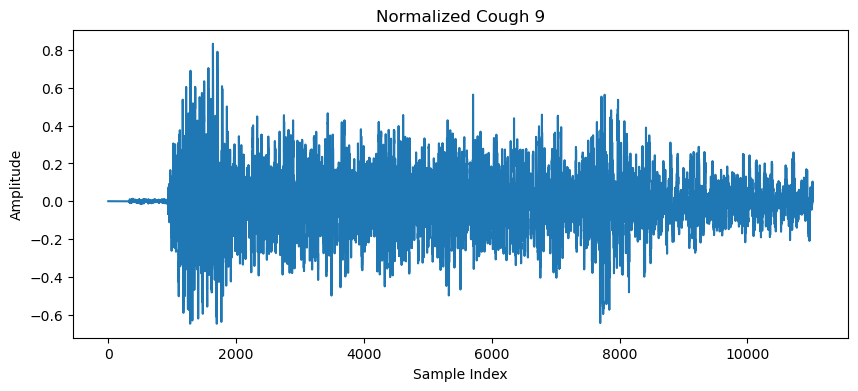

In [46]:
import pandas as pd
import numpy as np
import os
import librosa
import soundfile as sf
from segmentation import segment_cough
import matplotlib.pyplot as plt

def normalize_cough_duration(segmented_df_covid, target_duration_ms=500, fs=22050):
    normalized_coughs_covid = []
    for index, row in segmented_df_covid.iterrows():
        # Load the cough audio data
        file_path = row['File Path']
        audio_file = file_path
        cough_data, _ = librosa.load(audio_file, sr=fs)

        # Calculate the target length in samples
        target_length = int(target_duration_ms / 1000 * fs)

        # Pad or trim the audio signal
        if len(cough_data) < target_length:
            # Zero-pad the signal
            padded_signal = np.pad(cough_data, (0, target_length - len(cough_data)), 'constant')
            normalized_coughs_covid.append(padded_signal)
        else:
            # Trim the signal
            trimmed_signal = cough_data[:target_length]
            normalized_coughs_covid.append(trimmed_signal)

    return normalized_coughs_covid

def visualize_normalized_cough(normalized_coughs_covid, index):
    if index >= len(normalized_coughs_covid):
        print(f"Invalid index: {index}. Index should be between 0 and {len(normalized_coughs_covid) - 1}.")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(normalized_coughs_tbscreen[index])
    plt.title(f"Normalized Cough {index}")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.show()

# Example usage
normalized_coughs_covid = normalize_cough_duration(segmented_df_covid, target_duration_ms=500, fs=22050)
visualize_normalized_cough(normalized_coughs_covid, 9)  



In [47]:
segmented_df_covid

,File Path,Label,Gender,Age
0,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,0,49
1,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,0,19
2,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,0,27
3,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,1,26
4,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,1,32
...,...,...,...,...
1007,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,0,23
1008,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,0,50
1009,/Users/sudac/documents/UofA/COVID_cleaned_data...,0,1,26
1010,/Users/sudac/documents/UofA/COVID_cleaned_data...,1,1,47


In [48]:
# label_0_count = (segmented_df_covid[segmented_df_coda['label'] == 0]['participant']
#                  .value_counts()
#                  .loc[lambda x: x <= 3]
#                  .count())

# label_1_count = (segmented_df_covid[segmented_df_coda['label'] == 1]['participant']
#                  .value_counts()
#                  .loc[lambda x: x <= 3]
#                  .count())

# print("Number of patients with TB status 0 and 2 or fewer cough segments:", label_0_count)
# print("Number of patients with TB status 1 and 2 or fewer cough segments:", label_1_count)


In [78]:
mel_spectrogram_covid = np.array([calc_mel_spectrogram(y, sr) for y in normalized_coughs_covid])
X_tabular_covid  = segmented_df_covid.drop(['File Path', 'Label'], axis=1).values
y_covid = segmented_df_covid['Label']
X_mel_covid = np.expand_dims(mel_spectrogram_covid, -1)
print(X_mel_covid.shape)


(1012, 64, 22, 1)


# Train

In [50]:
# print null values
print(df_train.isnull().sum())

filename       0
label          0
sex            0
age            0
participant    0
dtype: int64


In [51]:
df_test

,filename,label,sex,age,participant
18,1652750733385-recording-1.wav,1,0,70,CODA_TB_0013
19,1652750746136-recording-1.wav,1,0,70,CODA_TB_0013
20,1652665393107-recording-1.wav,1,0,70,CODA_TB_0013
24,1647427284797-recording-1.wav,1,0,24,CODA_TB_0016
25,1647427334271-recording-1.wav,1,0,24,CODA_TB_0016
...,...,...,...,...,...
2434,1653381135949-recording-1.wav,0,0,36,CODA_TB_1080
2435,1653381077598-recording-1.wav,0,0,36,CODA_TB_1080
2436,1648629410726-recording-1.wav,0,1,54,CODA_TB_1082
2437,1648629427246-recording-1.wav,0,1,54,CODA_TB_1082


In [52]:
# Tabular data
X_tabular_train = df_train.drop(['participant', 'filename', 'label'], axis=1).values  

X_tabular_test  = df_test.drop(['participant', 'filename', 'label'], axis=1).values

# Labels
y_train = df_train['label']
y_test = df_test['label']

# Mel spectrogram data
X_mel_train = np.expand_dims(mel_spectrogram_train, -1)
X_mel_test = np.expand_dims(mel_spectrogram_test, -1)


In [53]:
print(X_mel_train.shape)

(1992, 64, 22, 1)


In [54]:
print(df_train.drop(['participant', 'filename', 'label',], axis=1).columns)

Index(['sex', 'age'], dtype='object')


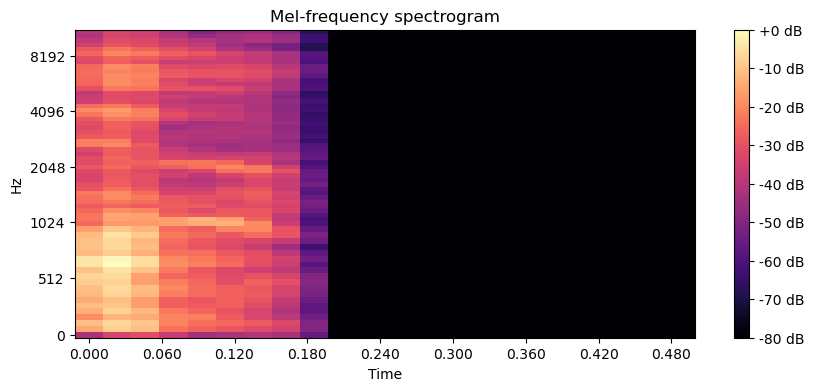

In [55]:
# display audio file with axis labels 
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_train[97], x_axis='time', y_axis='mel', sr=44100/2)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.show()

In [56]:
# input shapes
mel_input_shape = X_mel_train.shape[1:]  
tabular_input_shape = X_tabular_train.shape[1]
print(mel_input_shape)

(64, 22, 1)


In [57]:
print(X_tabular_test.shape[1])

2


In [58]:
from tensorflow.keras import layers, models

# Gated Activation Unit (GAU)
def gated_activation_unit(x):
    tanh_out = layers.Activation('tanh')(x)
    sigmoid_out = layers.Activation('sigmoid')(x)
    return layers.Multiply()([tanh_out, sigmoid_out])

# Multi-Head Self-Attention
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, heads, **kwargs):
        super(MultiHeadSelfAttention, self).__init__(**kwargs)
        self.heads = heads

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.heads == 0

        self.depth = self.d_model // self.heads

        self.query_dense = layers.Dense(self.d_model)
        self.key_dense = layers.Dense(self.d_model)
        self.value_dense = layers.Dense(self.d_model)

        self.combine_heads = layers.Dense(self.d_model)

    def call(self, inputs, **kwargs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Split the heads
        query = layers.Reshape((self.heads, self.depth))(query)
        key = layers.Reshape((self.heads, self.depth))(key)
        value = layers.Reshape((self.heads, self.depth))(value)

        # Apply scaled dot-product attention
        attention = layers.Attention()([query, key, value])
        attention = layers.Reshape((self.d_model,))(attention)

        # Combine heads
        output = self.combine_heads(attention)
        return output

# Model architecture
mel_input = layers.Input(shape=mel_input_shape, name='mel_input')
x = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(mel_input)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.MaxPooling2D()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = gated_activation_unit(x)

# Tabular input
tabular_input = layers.Input(shape=(tabular_input_shape,), name='tabular_input')
y = layers.Dense(1024)(tabular_input)
y = layers.Dense(256)(tabular_input)
y = layers.Dropout(0.15)(y)

# Multi-Head Self-Attention
attention = MultiHeadSelfAttention(heads=8)(x)
weighted_x = layers.Multiply()([x, attention])

# Concatenate the paths
combined = layers.Concatenate()([weighted_x, y])

# Dense layers for final classification
z = layers.Dense(512, activation='leaky_relu')(combined)
z = layers.LayerNormalization()(z)
z = layers.Dense(256, activation='leaky_relu')(z)
z = layers.Dropout(0.15)(z)
output = layers.Dense(1, activation='sigmoid', name='output')(z)

# Create the model
model = models.Model(inputs={'mel_input': mel_input, 'tabular_input': tabular_input}, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mel_input (InputLayer)         [(None, 64, 22, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 22, 64)   640         ['mel_input[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 64, 22, 64)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 11, 64)   0           ['layer_normalization[0][0]']

In [59]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import roc_curve, auc
# from tensorflow_addons.optimizers import AdamW

def focal_loss(y_true, y_pred, alpha=0.7, gamma=2):
    # Calculate the focal loss
    ce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    fl_loss = alpha * tf.pow(1 - pt, gamma) * ce_loss
    return fl_loss

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def s_plus_s(y_true, y_pred):
    return sensitivity(y_true, y_pred) + specificity(y_true, y_pred)

# Compile your model with the new metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss,
    metrics=['accuracy', 'AUC']
)


In [60]:
EPOCHS = 10

try:
    history = model.fit(
        {'mel_input': X_mel_train, 'tabular_input': X_tabular_train}, y_train,
        epochs=EPOCHS,
        validation_data=({'mel_input': X_mel_test, 'tabular_input': X_tabular_test}, y_test),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, restore_best_weights=True),
        ]
    )
except KeyboardInterrupt:
    print("Training interrupted manually.")


Epoch 1/10


2024-06-11 22:25:56.418863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


63/63 [==============================] - 10s 140ms/step - loss: 0.1384 - accuracy: 0.6837 - auc: 0.4919 - val_loss: 0.0759 - val_accuracy: 0.7605 - val_auc: 0.6113
Epoch 2/10
63/63 [==============================] - 9s 148ms/step - loss: 0.0901 - accuracy: 0.7144 - auc: 0.5289 - val_loss: 0.0821 - val_accuracy: 0.7605 - val_auc: 0.6059
Epoch 3/10
63/63 [==============================] - 10s 161ms/step - loss: 0.0912 - accuracy: 0.7043 - auc: 0.5367 - val_loss: 0.0800 - val_accuracy: 0.7605 - val_auc: 0.6125
Epoch 4/10
63/63 [==============================] - 9s 140ms/step - loss: 0.0896 - accuracy: 0.7159 - auc: 0.5309 - val_loss: 0.0795 - val_accuracy: 0.7605 - val_auc: 0.6080
Epoch 5/10
63/63 [==============================] - 9s 139ms/step - loss: 0.0875 - accuracy: 0.7179 - auc: 0.5416 - val_loss: 0.0781 - val_accuracy: 0.7605 - val_auc: 0.6086
Epoch 6/10
63/63 [==============================] - 9s 138ms/step - loss: 0.0845 - accuracy: 0.7204 - auc: 0.5555 - val_loss: 0.0740 - val_

In [61]:
# #load model
# model = tf.keras.models.load_model('small-model-81.4-model.h5', custom_objects={'MultiHeadSelfAttention':MultiHeadSelfAttention,'focal_loss': focal_loss, 'sensitivity': sensitivity, 'specificity': specificity, 's_plus_s': s_plus_s})

16/16 [==============================] - 0s 16ms/step
Optimal Threshold: 0.3842777
Sensitivity at Optimal Threshold: 0.39166666666666666
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45


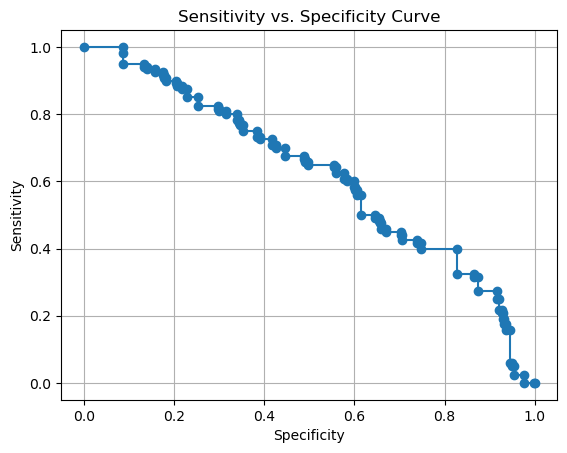

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Call model predict
y_pred = model.predict({'mel_input': X_mel_test, 'tabular_input': X_tabular_test})

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Convert probabilities to binary predictions using the optimal threshold
y_pred_binary = (y_pred > optimal_threshold).astype(int)

# Calculate confusion matrix with optimal threshold
conf_matrix_optimal = confusion_matrix(y_test, y_pred_binary)
tn_optimal, fp_optimal, fn_optimal, tp_optimal = conf_matrix_optimal.ravel()

# Calculate sensitivity and specificity at optimal threshold
sensitivity_optimal = tp_optimal / (tp_optimal + fn_optimal)
specificity_optimal = tn_optimal / (tn_optimal + fp_optimal)

# Print optimal threshold and sensitivity/specificity at that threshold
print("Optimal Threshold:", optimal_threshold)
print("Sensitivity at Optimal Threshold:", sensitivity_optimal)
print("Specificity at Optimal Threshold:", specificity_optimal)

# Calculate sensitivity at specificity = 0.70
desired_specificity = 0.70
sensitivity_at_specificity_70 = tpr[fpr >= (1 - desired_specificity)][0]
print("Sensitivity at Specificity 0.70:", sensitivity_at_specificity_70)

# Plot sensitivity vs. (1 - specificity) curve
plt.plot(1 - fpr, tpr, label='Sensitivity vs. (1 - Specificity) Curve', marker='o')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity vs. Specificity Curve')
plt.grid(True)
plt.show()

Max Metrics:
Optimal Threshold: 0.3843998
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.35964873


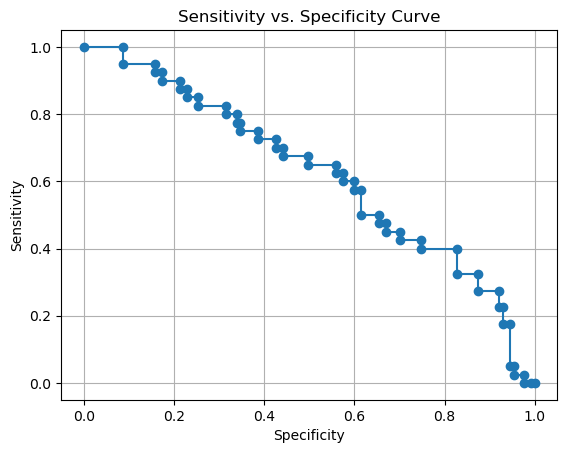

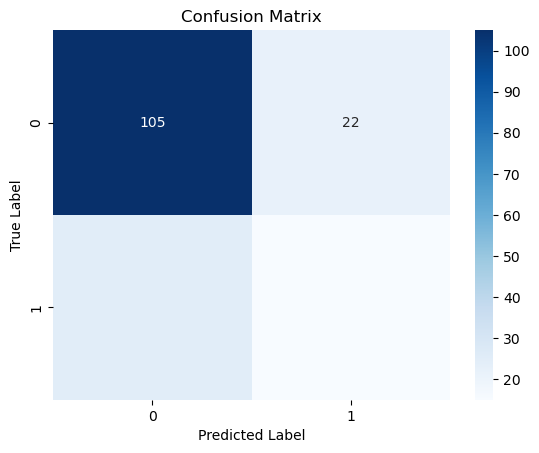

Confusion Matrix:
[[105  22]
 [ 25  15]]
Median Metrics:
Optimal Threshold: 0.384345
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.35562855


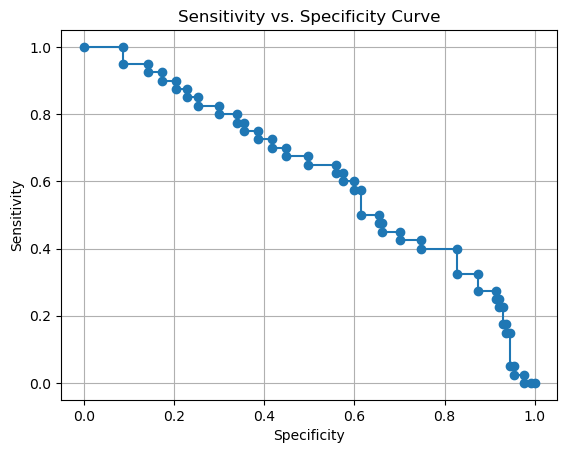

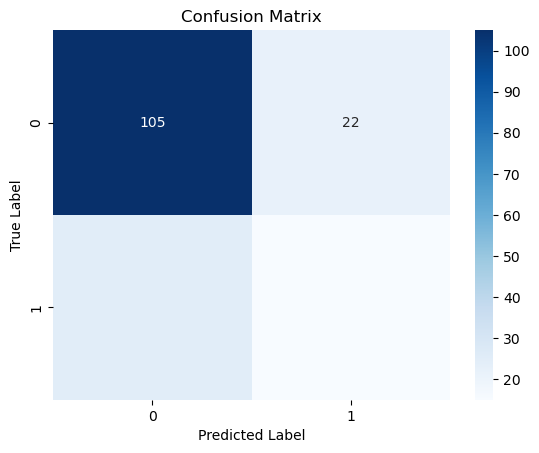

Confusion Matrix:
[[105  22]
 [ 25  15]]
Mean Metrics:
Optimal Threshold: 0.38434085
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.35562286


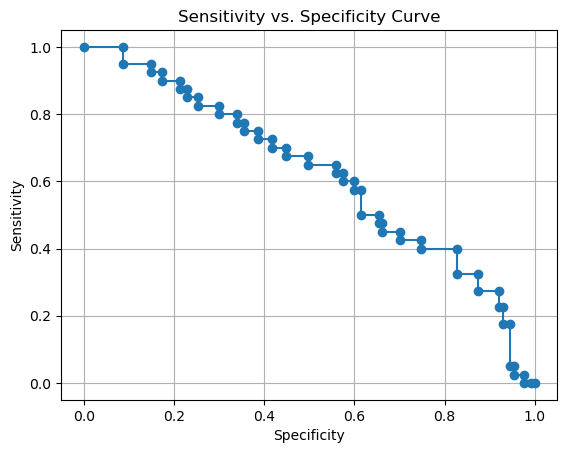

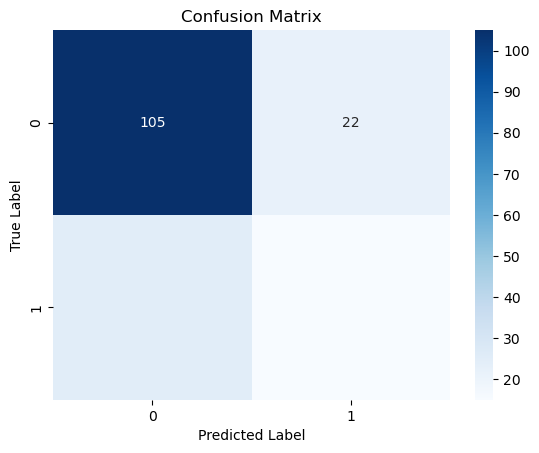

Confusion Matrix:
[[105  22]
 [ 25  15]]
Min Metrics:
Optimal Threshold: 0.3842777
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.35558453


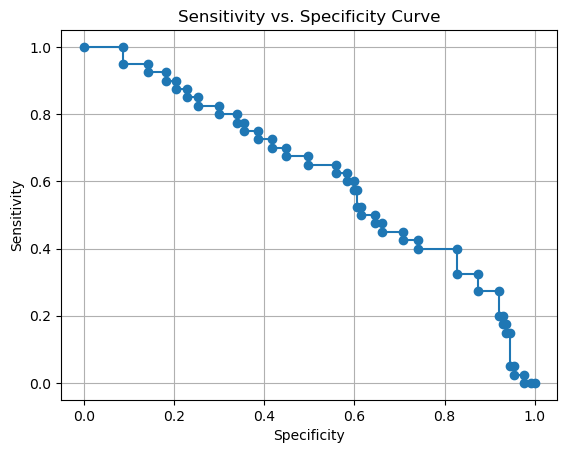

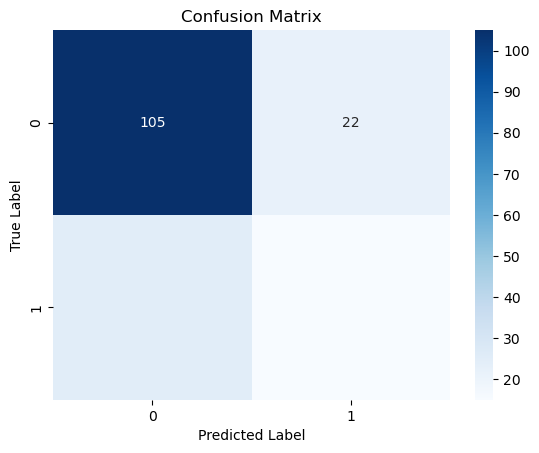

Confusion Matrix:
[[105  22]
 [ 25  15]]
25th Percentile Metrics:
Optimal Threshold: 0.38431134819984436
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.3556065410375595


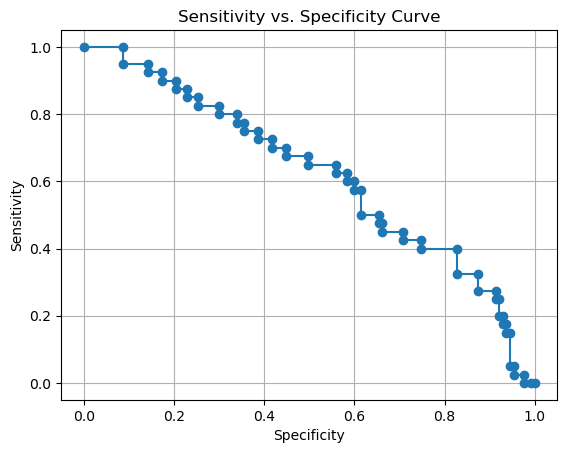

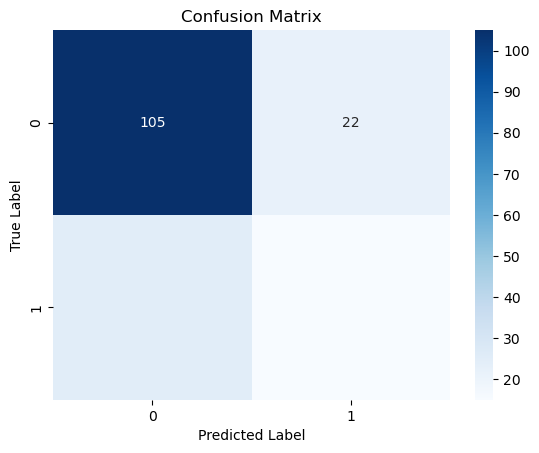

Confusion Matrix:
[[105  22]
 [ 25  15]]
65th Percentile Metrics:
Optimal Threshold: 0.38437239825725555
Sensitivity at Optimal Threshold: 0.4
Specificity at Optimal Threshold: 0.8267716535433071
Sensitivity at Specificity 0.70: 0.45
Threshold at Specificity 0.70: 0.35564203560352325


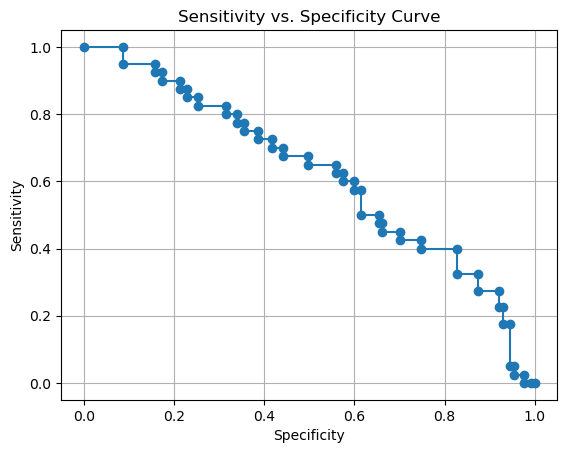

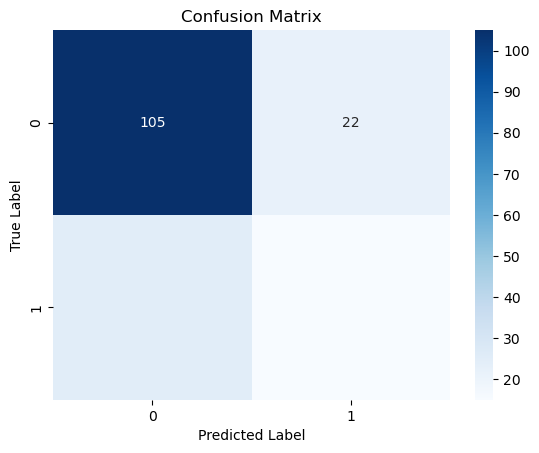

Confusion Matrix:
[[105  22]
 [ 25  15]]


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

def calculate_metrics(df):
    roc_auc_score(df['label'], df['probability'])  # print auc and auc curve
    fpr, tpr, thresholds = roc_curve(df['label'], df['probability'])

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold:", optimal_threshold)
    print("Sensitivity at Optimal Threshold:", tpr[optimal_idx])
    print("Specificity at Optimal Threshold:", 1 - fpr[optimal_idx])

    # Calculate sensitivity at specificity = 0.70
    desired_specificity = 0.70
    sensitivity_at_specificity_70 = tpr[fpr >= (1 - desired_specificity)][0]
    print("Sensitivity at Specificity 0.70:", sensitivity_at_specificity_70)
    # print the threshold that gives 70% specificity
    print("Threshold at Specificity 0.70:", thresholds[fpr >= (1 - desired_specificity)][0])
        
    # Plot sensitivity vs. (1 - specificity) curve
    plt.plot(1 - fpr, tpr, label='Sensitivity vs. (1 - Specificity) Curve', marker='o')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity vs. Specificity Curve')
    plt.grid(True)
    plt.show()
        
    # print the optimal confusion matrix using seaborn
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['label'], y_pred_2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    print("Confusion Matrix:")
    print(cm)

df_test.loc[:, 'probability'] = y_pred

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics(df)

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics(df)

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics(df)

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics(df)

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.25)
df.to_csv('25th-Percentile-Predictions.csv', index=False)
print("25th Percentile Metrics:")
calculate_metrics(df)

df = df_test.groupby(['participant'], as_index=False)[['probability', 'label']].quantile(.75)
b   df.to_csv('65th-Percentile-Predictions.csv', index=False)
print("65th Percentile Metrics:")
calculate_metrics(df)

In [64]:
df_test.head(20)

,filename,label,sex,age,participant,probability
18,1652750733385-recording-1.wav,1,0,70,CODA_TB_0013,0.283467
19,1652750746136-recording-1.wav,1,0,70,CODA_TB_0013,0.283389
20,1652665393107-recording-1.wav,1,0,70,CODA_TB_0013,0.283704
24,1647427284797-recording-1.wav,1,0,24,CODA_TB_0016,0.415540
25,1647427334271-recording-1.wav,1,0,24,CODA_TB_0016,0.415349
26,1647427303030-recording-1.wav,1,0,24,CODA_TB_0016,0.415277
36,1646029817490-recording-1.wav,0,0,57,CODA_TB_0023,0.304072
37,1646029845855-recording-1.wav,0,0,57,CODA_TB_0023,0.303886
38,1646029758974-recording-1.wav,0,0,57,CODA_TB_0023,0.303863
66,1646812324361-recording-1.wav,0,1,27,CODA_TB_0034,0.363987


In [65]:
df_test

,filename,label,sex,age,participant,probability
18,1652750733385-recording-1.wav,1,0,70,CODA_TB_0013,0.283467
19,1652750746136-recording-1.wav,1,0,70,CODA_TB_0013,0.283389
20,1652665393107-recording-1.wav,1,0,70,CODA_TB_0013,0.283704
24,1647427284797-recording-1.wav,1,0,24,CODA_TB_0016,0.415540
25,1647427334271-recording-1.wav,1,0,24,CODA_TB_0016,0.415349
...,...,...,...,...,...,...
2434,1653381135949-recording-1.wav,0,0,36,CODA_TB_1080,0.360723
2435,1653381077598-recording-1.wav,0,0,36,CODA_TB_1080,0.361016
2436,1648629410726-recording-1.wav,0,1,54,CODA_TB_1082,0.288166
2437,1648629427246-recording-1.wav,0,1,54,CODA_TB_1082,0.288387


# TB Screen Test

4/4 [==============================] - 0s 25ms/step
0.5277777777777778
AUC: 0.5277777777777778


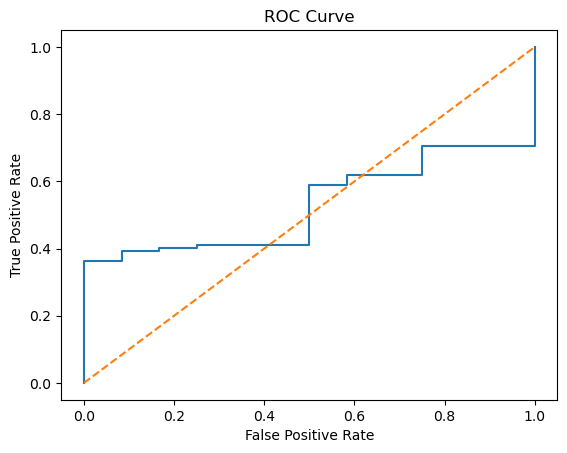

Threshold value is: 0.37642387
Sensitivity: 0.3627450980392157
Specificity: 1.0
[[12  0]
 [66 36]]


In [66]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_tbscreen, 'tabular_input':  X_tabular_tbscreen})
roc_auc = roc_auc_score(y_tbscreen, y_pred)

# add probability to df_test using .loc
segmented_df_tbscreen.loc[:, 'probability'] = y_pred

# save df_test to csv
segmented_df_tbscreen.to_csv('solicited-audio-test.csv', index=False)

print(roc_auc)

# also add print sensitivty and specifit on optimal threshold
# print auc  and auc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(segmented_df_tbscreen['class'], segmented_df_tbscreen['probability'])
print("AUC:", roc_auc_score(segmented_df_tbscreen['class'], segmented_df_tbscreen['probability']))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
print("Sensitivity:", tpr[optimal_idx])
print("Specificity:", 1 - fpr[optimal_idx])

# print the optimal confusion matrix using seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred_2 = np.where(segmented_df_tbscreen['probability'] > optimal_threshold, 1, 0)
cm = confusion_matrix(segmented_df_tbscreen['class'], y_pred_2)
print(cm)

Max Metrics:
Threshold: 0.3408356
Sensitivity at Threshold: 0.38235294117647056
Specificity at Threshold: 1.0
Sensitivity at Specificity 0.70: 0.38235294117647056


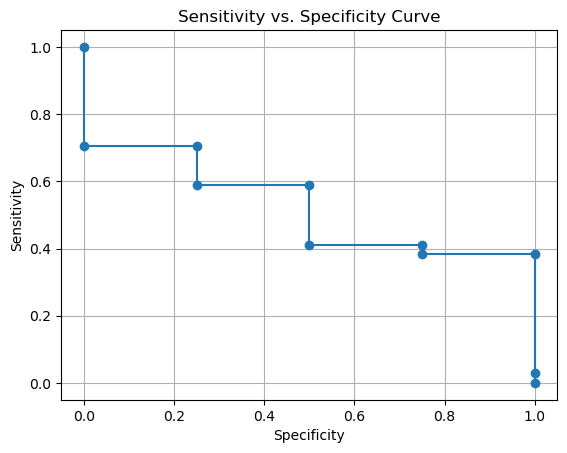

Confusion Matrix:
[[ 1  3]
 [11 23]]
Median Metrics:
Threshold: 0.3408356
Sensitivity at Threshold: 0.38235294117647056
Specificity at Threshold: 1.0
Sensitivity at Specificity 0.70: 0.38235294117647056


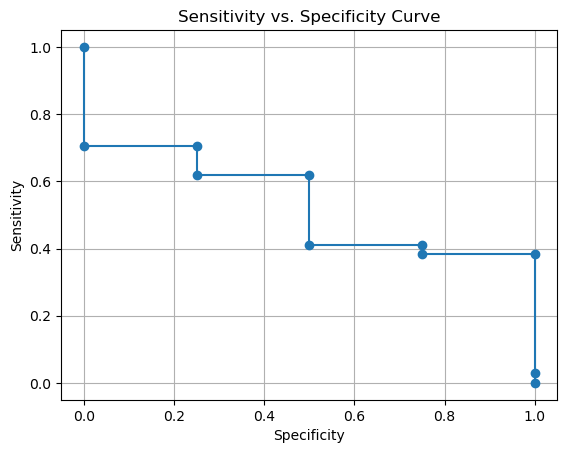

Confusion Matrix:
[[ 1  3]
 [11 23]]
Mean Metrics:
Threshold: 0.3408356
Sensitivity at Threshold: 0.38235294117647056
Specificity at Threshold: 1.0
Sensitivity at Specificity 0.70: 0.38235294117647056


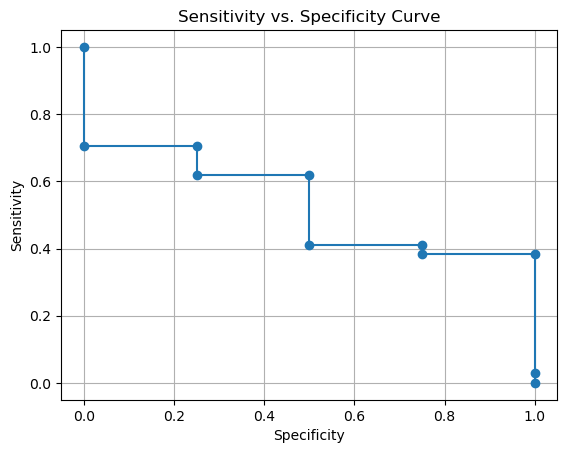

Confusion Matrix:
[[ 1  3]
 [11 23]]
Min Metrics:
Threshold: 0.3408356
Sensitivity at Threshold: 0.38235294117647056
Specificity at Threshold: 1.0
Sensitivity at Specificity 0.70: 0.38235294117647056


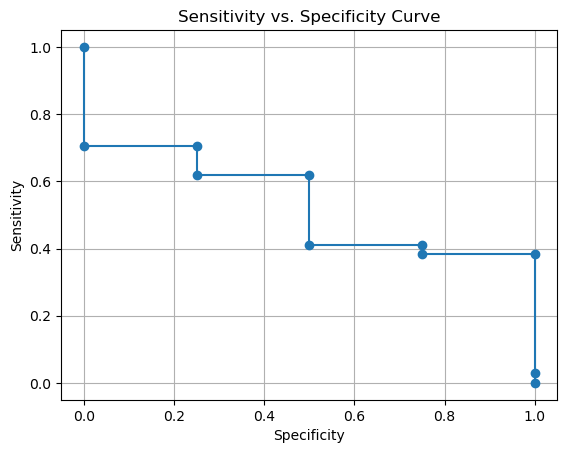

Confusion Matrix:
[[ 1  3]
 [11 23]]
90th Percentile Metrics:
Threshold: 0.3408356
Sensitivity at Threshold: 0.38235294117647056
Specificity at Threshold: 1.0
Sensitivity at Specificity 0.70: 0.38235294117647056


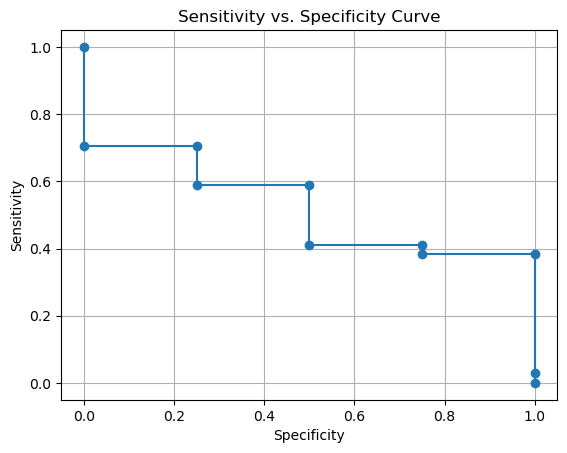

Confusion Matrix:
[[ 1  3]
 [11 23]]


In [67]:
def calculate_metrics():
    roc_auc_score(df['class'], df['probability'])  # print auc and auc curve
    fpr, tpr, thresholds = roc_curve(df['class'], df['probability'])

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = 0.3408356
    print("Threshold:", optimal_threshold)
    print("Sensitivity at Threshold:", tpr[optimal_idx])
    print("Specificity at Threshold:", 1 - fpr[optimal_idx])

    # Calculate sensitivity at specificity = 0.70
    desired_specificity = 0.80
    sensitivity_at_specificity_70 = tpr[fpr >= (1 - desired_specificity)][0]
    print("Sensitivity at Specificity 0.70:", sensitivity_at_specificity_70)
        
    # Plot sensitivity vs. (1 - specificity) curve
    plt.plot(1 - fpr, tpr, label='Sensitivity vs. (1 - Specificity) Curve', marker='o')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity vs. Specificity Curve')
    plt.grid(True)
    plt.show()
        
    # print the optimal confusion matrix using seaborn
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['class'], y_pred_2)
    print("Confusion Matrix:")
    print(cm)

segmented_df_tbscreen.loc[:, 'probability'] = y_pred

df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].max()
df.to_csv('Max-Predictions.csv', index=False)
print("Max Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].median()
df.to_csv('Median-Predictions.csv', index=False)
print("Median Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].mean()
df.to_csv('Mean-Predictions.csv', index=False)
print("Mean Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].min()
df.to_csv('Min-Predictions.csv', index=False)
print("Min Metrics:")
calculate_metrics()
df = segmented_df_tbscreen.groupby(['subject'], as_index=False)[['probability', 'class']].quantile(.9)
df.to_csv('90th-Percentile-Predictions.csv', index=False)
print("90th Percentile Metrics:")
calculate_metrics()


In [68]:
# from sklearn.inspection import permutation_importance
# from sklearn.metrics import accuracy_score
# import numpy as np
# import matplotlib.pyplot as plt

# # Get the feature names
# feature_names = df_train.drop(['label', 'participant', 'filename', 'relative_path', 'sound_prediction_score', 'tb_status'], axis=1).columns
# print(feature_names)

# def wrapper_predict(X):
#     return model.predict([X_mel_train, X])

# def keras_accuracy(estimator, X, y_true):
#     y_pred = estimator.predict(X)
#     return accuracy_score(y_true, np.round(y_pred))

# class KerasWrapper:
#     def __init__(self, model):
#         self.model = model

#     def fit(self, X, y):
#         self.model.fit(X, y)

#     def predict(self, X):
#         return wrapper_predict(X)

# # Create a wrapped model
# wrapped_model = KerasWrapper(model)

# # Use the wrapped model with permutation_importance
# result = permutation_importance(wrapped_model, X_tabular_train, y_train, scoring=keras_accuracy, n_repeats=2, random_state=42, n_jobs=1)

# # Sort the features by importance
# sorted_idx = result.importances_mean.argsort()

# # Plot the permutation importances
# fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T,
#            vert=False, labels=np.array(feature_names)[sorted_idx])
# ax.set_title("Permutation Importances (train set)")
# fig.tight_layout()
# plt.show()



In [86]:
import pandas as pd

# Assuming y_covid is already defined
y_covid = segmented_df_covid['Label']

# Print the type of y_covid to confirm it's a pandas Series
print(type(y_covid))

# Create a Series of zeros with the same index and length as y_covid
y_covid_zeros = pd.Series(0, index=y_covid.index)

# Print the new y_covid_zeros to verify
print(y_covid_zeros)


<class 'pandas.core.series.Series'>
0       0
1       0
2       0
3       0
4       0
       ..
1007    0
1008    0
1009    0
1010    0
1011    0
Length: 1012, dtype: int64


# Covid Test

In [87]:
from sklearn.metrics import roc_auc_score
y_pred = model.predict({'mel_input': X_mel_covid, 'tabular_input':  X_tabular_covid})
roc_auc = roc_auc_score(y_covid, y_pred)

# add probability to df_test using .loc
segmented_df_covid.loc[:, 'probability'] = y_pred

# save df_test to csv
segmented_df_covid.to_csv('solicited-audio-test.csv', index=False)

print(roc_auc)

# also add print sensitivty and specifit on optimal threshold
# print auc  and auc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(segmented_df_covid['Label'], segmented_df_covid['probability'])
print("AUC:", roc_auc_score(segmented_df_covid['Label'], segmented_df_covid['probability']))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
print("Sensitivity:", tpr[optimal_idx])
print("Specificity:", 1 - fpr[optimal_idx])

# print the optimal confusion matrix using seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred_2 = np.where(segmented_df_covid['probability'] > optimal_threshold, 1, 0)
cm = confusion_matrix(segmented_df_covid['Label'], y_pred_2)
print(cm)

InvalidArgumentError: Graph execution error:

Detected at node 'model/dense_2/BiasAdd' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/1v/mvl__pn17d9dwy2vk2wqw97m0000gn/T/ipykernel_74212/574141563.py", line 2, in <module>
      y_pred = model.predict({'mel_input': X_mel_covid, 'tabular_input':  X_tabular_covid})
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/uofa/lib/python3.11/site-packages/keras/layers/core/dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model/dense_2/BiasAdd'
Matrix size-incompatible: In[0]: [32,3], In[1]: [2,256]
	 [[{{node model/dense_2/BiasAdd}}]] [Op:__inference_predict_function_11363]

Max Metrics:
Threshold: 0.3780149
Sensitivity at Threshold: 0.42857142857142855
Specificity at Threshold: 0.6600418410041842
Sensitivity at Specificity 0.70: 0.35714285714285715


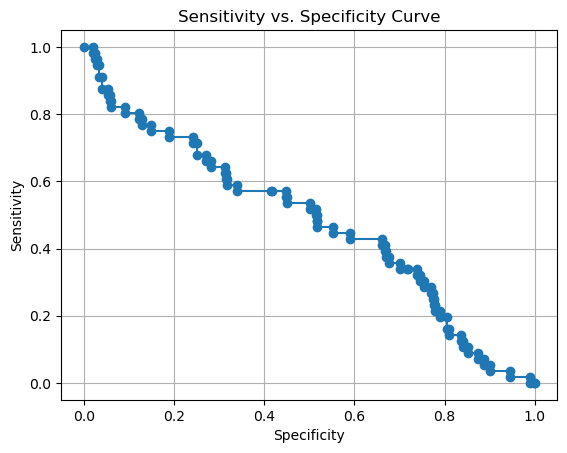

Confusion Matrix:
[[498 458]
 [ 30  26]]


In [88]:
def calculate_metrics():
    roc_auc_score(df['Label'], df['probability'])  # print auc and auc curve
    fpr, tpr, thresholds = roc_curve(df['Label'], df['probability'])

    # the sensitivity and specificity for the threshold that maximizes the sum of sensitivity and specificity
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = 0.3780149
    print("Threshold:", optimal_threshold)
    print("Sensitivity at Threshold:", tpr[optimal_idx])
    print("Specificity at Threshold:", 1 - fpr[optimal_idx])

    # Calculate sensitivity at specificity = 0.70
    desired_specificity = 0.70
    sensitivity_at_specificity_70 = tpr[fpr >= (1 - desired_specificity)][0]
    print("Sensitivity at Specificity 0.70:", sensitivity_at_specificity_70)
        
    # Plot sensitivity vs. (1 - specificity) curve
    plt.plot(1 - fpr, tpr, label='Sensitivity vs. (1 - Specificity) Curve', marker='o')
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Sensitivity vs. Specificity Curve')
    plt.grid(True)
    plt.show()
        
    # print the optimal confusion matrix using seaborn
    y_pred_2 = np.where(df['probability'] > optimal_threshold, 1, 0)
    cm = confusion_matrix(df['Label'], y_pred_2)
    print("Confusion Matrix:")
    print(cm)

segmented_df_covid.loc[:, 'probability'] = y_pred

df = segmented_df_covid
print("Max Metrics:")
calculate_metrics()
